#**BA810 Team 9 Fraud Detection**
Contributers: Chuheng Yu, Linting Wang, Yuhan Wang, Tyler Christoforo

##Data Preparation



##Import all packages we need

In [ ]:
import pandas as pd
from google.cloud import storage
from google.colab import auth
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as pip
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from scipy.stats import loguniform,randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_squared_error

##Mount the drive and import the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_folder = '/content/drive/Shareddrives/BA810/'
data = pd.read_csv(data_folder + 'onlinefraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Description

### Colomn Description
step:   represents a unit of time where 1 step equals 1 hour.

type:   type of online transaction. 

amount: the amount of the transaction

nameOrig: customer starting the transaction

oldbalanceOrg: balance before the transaction

newbalanceOrig: balance after the transaction

nameDest: recipient of the transaction

oldbalanceDest: initial balance of recipient before the transaction

newbalanceDest: the new balance of recipient after the transaction

isFraud: fraud transaction

### Data description

In [ ]:
#drop the 'isFlaggedFraud' colomn
#data['isFraud'] = data['isFraud'].astype('category') ## need comment?
data = data.drop(['isFlaggedFraud'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [ ]:
#Check the fraud data
Fraud = data[data['isFraud']== 1]
Fraud.info()
Fraud['type'].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8213 entries, 2 to 6362619
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            8213 non-null   int64  
 1   type            8213 non-null   object 
 2   amount          8213 non-null   float64
 3   nameOrig        8213 non-null   object 
 4   oldbalanceOrg   8213 non-null   float64
 5   newbalanceOrig  8213 non-null   float64
 6   nameDest        8213 non-null   object 
 7   oldbalanceDest  8213 non-null   float64
 8   newbalanceDest  8213 non-null   float64
 9   isFraud         8213 non-null   int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 705.8+ KB


count         8213
unique           2
top       CASH_OUT
freq          4116
Name: type, dtype: object

In [ ]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

## Visualization

In [ ]:
#draw a graph to show the percentage of each transaciton type

type = data["type"].value_counts()
transactions = type.index
number = type.values

figure = px.pie(data, 
             values=number, 
             names=transactions,hole = 0.5, 
             title="Percentage of Transaction Type", width=700, height=400)
figure.show()

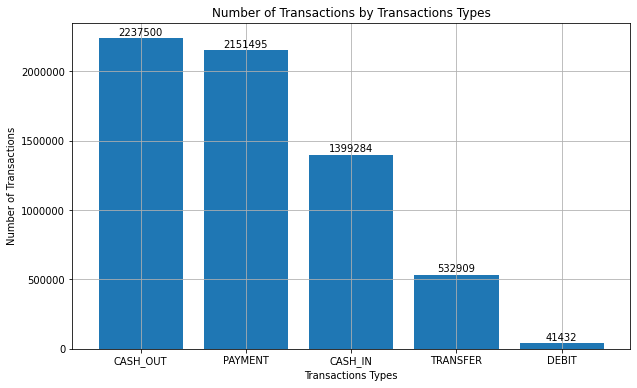

In [ ]:
#number of transactions per type

graph2 = data['type'].value_counts().plot(kind = 'bar', rot = 0, width = 0.8, figsize = (10,6), grid=True)
plt.ticklabel_format(style='plain', axis='y')
for rect in graph2.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    graph2.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

graph2.set_ylabel('Number of Transactions')
graph2.set_xlabel('Transactions Types')
graph2.set_title('Number of Transactions by Transactions Types')
    
plt.show()


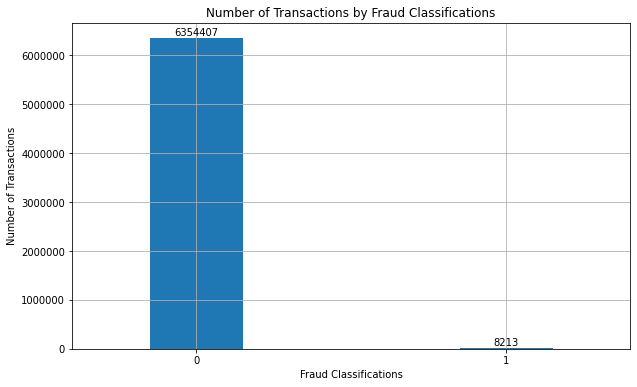

In [ ]:
#draw a hist graph group by 'isFraud'

graph1 = data['isFraud'].value_counts().plot(kind = 'bar', rot = 0, width = 0.3, figsize = (10,6), grid=True)
plt.ticklabel_format(style='plain', axis='y')
for rect in graph1.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    graph1.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
graph1.set_ylabel('Number of Transactions')
graph1.set_xlabel('Fraud Classifications')
graph1.set_title('Number of Transactions by Fraud Classifications')
plt.show()

Grouping by 'isFraud' and type, and aggerate them by mean and count. By visualizing them, we find that Fraud only happened in cash_out and transfer. This make sense since cash_in, debit and payment is very unlikely to have a fraud situation.

In [ ]:
# data['isFlaggedFraud'].value_counts()
column_names = ['type','isFraud']
summaries = {'step':'mean','amount': 'mean', 'nameOrig': 'count','oldbalanceOrg': 'mean','newbalanceOrig': 'mean','oldbalanceDest': 'mean','newbalanceDest': 'mean'}
flag = data.groupby(by = column_names).agg(summaries)
flag.head(20)

step        amount  nameOrig  oldbalanceOrg  \
type     isFraud                                                      
CASH_IN  0        244.490093  1.689202e+05   1399284   3.590464e+06   
CASH_OUT 0        240.667014  1.739172e+05   2233384   4.342923e+04   
         1        367.720360  1.455103e+06      4116   1.453869e+06   
DEBIT    0        248.440481  5.483665e+03     41432   6.864734e+04   
PAYMENT  0        244.378179  1.305760e+04   2151495   6.821683e+04   
TRANSFER 0        245.708590  9.062290e+05    528812   4.055876e+04   
         1        369.110569  1.480892e+06      4097   1.846374e+06   

                  newbalanceOrig  oldbalanceDest  newbalanceDest  
type     isFraud                                                  
CASH_IN  0          3.759379e+06    1.587919e+06    1.467105e+06  
CASH_OUT 0          1.750626e+04    1.498519e+06    1.689744e+06  
         1          7.258688e+01    1.084918e+06    2.549545e+06  
DEBIT    0          6.516165e+04    1.493136e+06    1.513003e+06  
PAYMENT  0          6.183789e+04    0.000000e+00    0.000000e+00  
TRANSFER 0          7.380372e+03    2.587490e+06    3.582075e+06  
         1          3.856046e+05    1.073383e+03    3.981411e+03

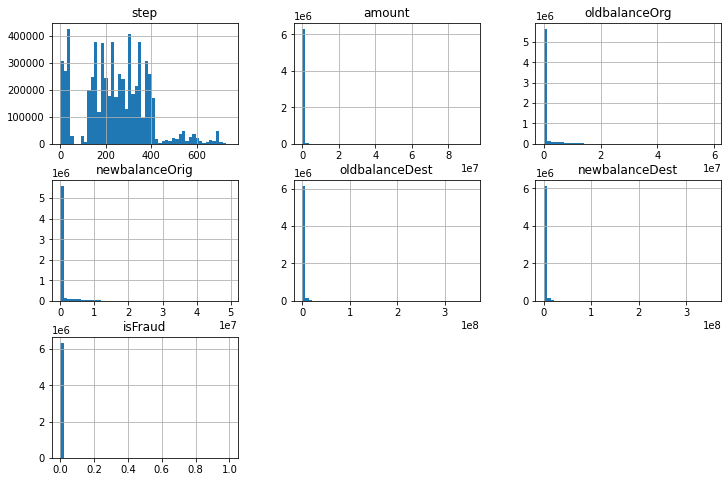

In [ ]:
#data distribution
data.hist(bins=50, figsize=(12, 8))
plt.show()

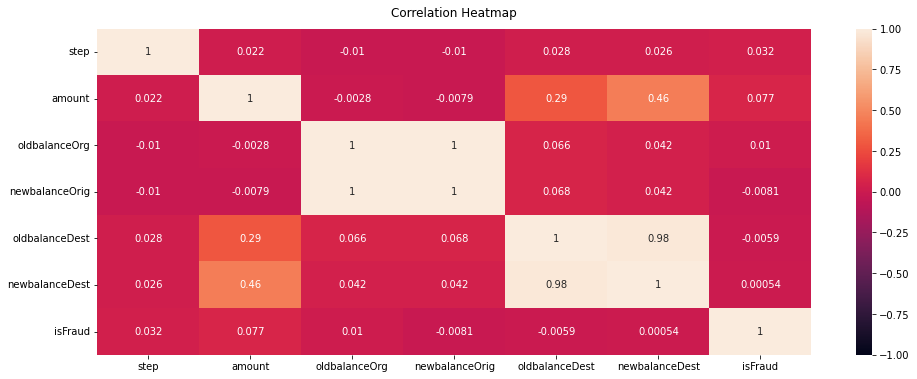

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#Feature Engineering

This section includes the creation new columns named as transferPercentage, errorDest and errorOrig.

* transferPercentage represents the fraction of amount out of the 
original balance before the tranaction.

* errorDest and errorOrig are columns used to check if the original balance and destination balance are correct. 


Then, we revise the 'newbalanceDest' column, specifically when newbalanceDest and oldbalanceDest are all zero, we fill the value with the amount of that transaction. The reason for this is that there are transactions with an amount, but destination balance has no change, evidently these transactions are very likely to be fradulent. Further, these tranactions take up a much larger percentage in fraud counts.


In [ ]:
data['transferPercentage'] = round(data['amount']/data['oldbalanceOrg'],2)
data.replace([np.inf, -np.inf], 0, inplace=True)
data['errorDest'] = data['newbalanceOrig'] + data['amount'] - data['oldbalanceOrg']
data['errorOrig'] = data['oldbalanceDest'] + data['amount'] - data['newbalanceDest']
data['newbalanceDest'] = np.where((data['newbalanceDest']==0)&(data['oldbalanceDest']==0), data['amount'], data['newbalanceDest'])

We dropped the rows where amount equals to zero, which likely means there was no real trasaction happened or the transaction did not go through.Additionally, we dropped the 'nameOrig' and 'nameDest' column, since it is hard to extract useful information from them. Lastly, we change the data type of the 'type' column to category.

In [ ]:
data = data[data['amount'] != 0]
data = data.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)
data['type'] = data['type'].astype('category')
data = data.drop(['nameOrig', 'nameDest'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6362604 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column              Dtype   
---  ------              -----   
 0   step                int64   
 1   type                category
 2   amount              float64 
 3   isFraud             int64   
 4   transferPercentage  float64 
 5   errorDest           float64 
 6   errorOrig           float64 
dtypes: category(1), float64(4), int64(2)
memory usage: 345.9 MB


Display the correlation between isFraud and other variables.

# Modeling



## split the training set and test set

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop("isFraud", axis=1)
y = data["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
X_train.shape, X_test.shape

((5090083, 6), (1272521, 6))

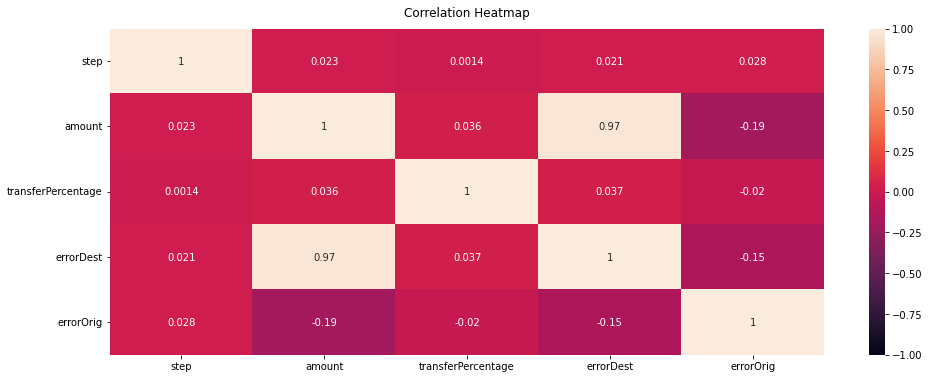

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Build the Pipeline

We create two different pipeline for numerical and categorical variables. 

Numerical variables include 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'transferPercentage', 'errorDest' and 'errorOrig'; 

Categorical variables include 'type'.

For numerical variables, we standardized them and impute the null values with the median. For categorical variables, we impute the null values with the most frequent type, and process them with oneHotEncoder.

In [ ]:
num_column = X_train.select_dtypes(exclude="category").columns
num_pipeline = Pipeline([
        ('standard', StandardScaler()),
        ('imputer', SimpleImputer(strategy='median'))
    ])

cat_column = X_train.select_dtypes(include="category").columns
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder())
    ])

# dest_check = X_train[(X_train['oldbalanceDest']==0)&(X_train['newbalanceDest']==0)]

preprocess = ColumnTransformer([
    ('num', num_pipeline, num_column),
    ('cat', cat_pipeline, cat_column)
])

In [ ]:
set_config(display='diagram') # graphically shows the pipeline when printed

preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standard', StandardScaler()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['step', 'amount', 'transferPercentage', 'errorDest', 'errorOrig'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder())]),
                                 Index(['type'], dtype='object'))])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5090083 entries, 1658888 to 3072567
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   step                int64   
 1   type                category
 2   amount              float64 
 3   transferPercentage  float64 
 4   errorDest           float64 
 5   errorOrig           float64 
dtypes: category(1), float64(4), int64(1)
memory usage: 237.9 MB


After we combine the categorical and numerical pipeline into a preprocess pipeline, we then pass them through RandomOverSampler and RandomUnderSampler. 

Having gone through both random sampling methods can result in overall improved performance. On the one hand, under sampler effectively reduces bias for the majority rows; On the other hand, over sampler helps balance the target outcome rows, since the records of non-fraud is much larger in this dataset.

In [ ]:
test_pip = pip([('transform', preprocess),
               ('oversample', RandomOverSampler(sampling_strategy=0.1)),
               ('undersample', RandomUnderSampler(sampling_strategy='majority'))
])
test_pip

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['step', 'amount', 'transferPercentage', 'errorDest', 'errorOrig'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['type'], dtype='object'))])),
                ('oversample', RandomOverSampler(sampling_strategy=0.1)),
                ('undersample',
                 RandomUnderSampler(sampling_strategy='majority'))])

##Model Selection

We implemented three classification models: logistic regression classificaiton model, decision tree classsification model, and random forest classification model. 

To begin, we use basic parameters of each model to roughly estimate the performance of each model. And evaluate them by four kinds of sccore: accuracy, auc, precision and recall.

Based on the result of each model, we find out logistic regression is not suitable for this dataset. With random forest providing the best result. Decision tree's result is in the middle of the two models.

As a result, we decide to continue with decision tree and random forest into our next steps.

###Logistic Regression

Logistic Regression is the statistical fitting of an s-curve logistic or logit function to a dataset in order to calculate the probability of the occurrence of a specific categorical event based on the values of a set of independent variables. 


In [ ]:
#add the logistic regression estimator into pipeline.
lg_cla = pip([('transform', preprocess),
               ('oversample', RandomOverSampler(sampling_strategy=0.1)),
               ('undersample', RandomUnderSampler(sampling_strategy='majority')),
               ('logistic', LogisticRegression(penalty='l2',solver="liblinear", random_state=42))
])
lg_cla

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['step', 'amount', 'transferPercentage', 'errorDest', 'errorOrig'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['type'], dtype='object'))])),
                ('oversample', RandomOverSampler(sampling_strategy=0.1)),
                ('undersample',
                 RandomUnderSampler(sampling_strategy='majority')),
                ('logistic',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [ ]:
lg_cla.fit(X_train, y_train)
y_pred_lg = lg_cla.predict(X_test)

Examining the scores in the next block, the precision score is only 2.62%. That means we have too many cases that are not default but are treated as default in this model.



In [ ]:
#print score for logistic regression
print(f'Test accuracy score was {accuracy_score(y_test, y_pred_lg):2.2%}.')
print(f'Test balanced accuracy score was {balanced_accuracy_score(y_test, y_pred_lg):2.2%}.')
print(f'Test auc score was {roc_auc_score(y_test, y_pred_lg):2.2%}.')
print(f'Test precision score was {precision_score(y_test, y_pred_lg):2.2%}.')#precision score was just 2.62 means lots of non fraud marked as 1.
print(f'Test recall score was {recall_score(y_test, y_pred_lg):2.2%}.')

Test accuracy score was 95.07%.
Test balanced accuracy score was 94.88%.
Test auc score was 94.88%.
Test precision score was 2.42%.
Test recall score was 94.69%.


              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270882
           1       0.02      0.95      0.05      1639

    accuracy                           0.95   1272521
   macro avg       0.51      0.95      0.51   1272521
weighted avg       1.00      0.95      0.97   1272521



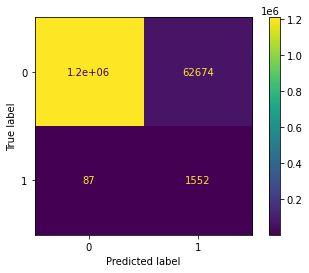

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lg);
print(classification_report(y_test, y_pred_lg))

###Decision Tree

A decision tree is a supervised learning technique that has a pre-defined target variable and is most often used in classification problems. This tree can be applied to either categorical or continuous input & output variables. The training process resembles a flow chart, with each internal (non-leaf) node a test of an attribute, each branch is the outcome of that test, and each leaf (terminal) node contains a class label. The uppermost node in the tree is called the root node.


In [ ]:
tree_cla = pip([('transform', preprocess),
               ('oversample', RandomOverSampler(sampling_strategy=0.1)),
               ('undersample', RandomUnderSampler(sampling_strategy='majority')),
               ('tree', DecisionTreeClassifier(max_depth = 3, random_state=42))
])
tree_cla

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['step', 'amount', 'transferPercentage', 'errorDest', 'errorOrig'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['type'], dtype='object'))])),
                ('oversample', RandomOverSampler(sampling_strategy=0.1)),
                ('undersample',
                 RandomUnderSampler(sampling_strategy='majority')),
                ('tree', DecisionTreeClassifier(max_depth=3, random_state=42))])

In [ ]:
tree_cla.fit(X_train, y_train)
y_pred_tree = tree_cla.predict(X_test)

From the results printed, we can see that the result in decision tree is much better than logistic regression, especially the precision score. It is now 82.15%.

In [ ]:
#print score and confusion matrix for logistic regression
print(f'Test accuracy score was {accuracy_score(y_test, y_pred_tree):2.2%}.')
print(f'Test balanced accuracy score was {balanced_accuracy_score(y_test, y_pred_tree):2.2%}.')
print(f'Test auc score was {roc_auc_score(y_test, y_pred_tree):2.2%}.')
print(f'Test precision score was {precision_score(y_test, y_pred_tree):2.2%}.')#precision score was just 2.62 means lots of non fraud marked as 1.
print(f'Test recall score was {recall_score(y_test, y_pred_tree):2.2%}.')

Test accuracy score was 99.95%.
Test balanced accuracy score was 99.82%.
Test auc score was 99.82%.
Test precision score was 73.87%.
Test recall score was 99.69%.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       0.74      1.00      0.85      1639

    accuracy                           1.00   1272521
   macro avg       0.87      1.00      0.92   1272521
weighted avg       1.00      1.00      1.00   1272521



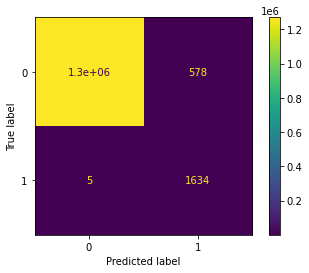

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree);
print(classification_report(y_test, y_pred_tree))

### Random Forest
Random Forest is a robust machine learning algorithm that can be used for a variety of tasks including regression and classification. It is an ensemble method, meaning that a random forest model is made up of a large number of small decision trees, called estimators, which each produce their own predictions. The random forest model combines the predictions of the estimators to produce a more accurate prediction.


In [ ]:
#random forest
rf_cla = pip([('transform', preprocess),
               ('oversample', RandomOverSampler(sampling_strategy=0.1)),
               ('undersample', RandomUnderSampler(sampling_strategy='majority')),
               ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
])
rf_cla

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['step', 'amount', 'transferPercentage', 'errorDest', 'errorOrig'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['type'], dtype='object'))])),
                ('oversample', RandomOverSampler(sampling_strategy=0.1)),
                ('undersample',
                 RandomUnderSampler(sampling_strategy='majority')),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [ ]:
rf_cla.fit(X_train, y_train)
y_pred_rf = rf_cla.predict(X_test)

The results in the Random Forest model are the best by all metrics.  The accuracy is 100%, while the other scores are also the highest among the three.

In [ ]:
#print score and confusion matrix for logistic regression
print(f'Test accuracy score was {accuracy_score(y_test, y_pred_rf):2.2%}.')
print(f'Test balanced accuracy score was {balanced_accuracy_score(y_test, y_pred_rf):2.2%}.')
print(f'Test auc score was {roc_auc_score(y_test, y_pred_rf):2.2%}.')
print(f'Test precision score was {precision_score(y_test, y_pred_rf):2.2%}.')#precision score was just 2.62 means lots of non fraud marked as 1.
print(f'Test recall score was {recall_score(y_test, y_pred_rf):2.2%}.')

Test accuracy score was 99.98%.
Test balanced accuracy score was 99.78%.
Test auc score was 99.78%.
Test precision score was 88.50%.
Test recall score was 99.57%.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       0.89      1.00      0.94      1639

    accuracy                           1.00   1272521
   macro avg       0.94      1.00      0.97   1272521
weighted avg       1.00      1.00      1.00   1272521



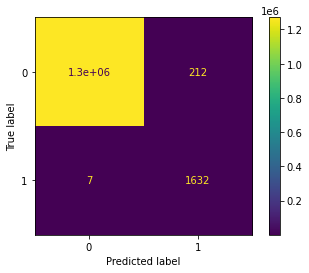

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf);
print(classification_report(y_test, y_pred_rf))


##Hyper-parameters tuning
We use three methods for tuning the parameters: grid search, random search and halving search; Evaluate the results with balanced accuracy.

1. We choose certain possible combinations of parameters for each model based on our own experience and try each using grid search. 

2. We use random search to expand the possible range for find a better model. 

3. Then, we compared the results in step one and step two, to find a better range for each parameters. 

4. Finally, we change the parameters range and use halving search and compare the result to get the best model. Using halving search can reduce the running time significantly.

After evaluating the results, we found the best hyper-parameter combination in halving search method for prediction. Using **17** as **random forest max depth** and **8** as **random forest minimum samples leaf**.

The mean test balanced accuracy score is 99.81%, and the standard test score is 0.43%.

###Hyper-parameters tuning for Decision Tree

**Grid search**

In [ ]:
param_grid_tree = [ 
    {'tree__max_depth': [2, 5, 10], 
    'tree__max_leaf_nodes': [2, 5, 10]}, 
    ]
grid_search_tree = GridSearchCV(tree_cla, param_grid_tree, cv=3, scoring='balanced_accuracy')
grid_search_tree.fit(X_train, y_train)

grid_search_tree.best_estimator_
cv_res_tree_grid = pd.DataFrame(grid_search_tree.cv_results_)
cv_res_tree_grid.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_tree_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,10.323088,0.084073,1.143329,0.009727,10,5,"{'tree__max_depth': 10, 'tree__max_leaf_nodes'...",0.995949,0.997774,0.998225,0.997316,0.000984,1
4,10.119638,0.033717,1.134902,0.014186,5,5,"{'tree__max_depth': 5, 'tree__max_leaf_nodes': 5}",0.995948,0.997773,0.998225,0.997315,0.000984,2
8,10.739052,0.065563,1.153312,0.010335,10,10,"{'tree__max_depth': 10, 'tree__max_leaf_nodes'...",0.995789,0.997819,0.998280,0.997296,0.001082,3
5,10.553458,0.078384,1.140186,0.006728,5,10,"{'tree__max_depth': 5, 'tree__max_leaf_nodes':...",0.995790,0.997814,0.998277,0.997294,0.001080,4
1,9.690607,0.059566,1.130563,0.005127,2,5,"{'tree__max_depth': 2, 'tree__max_leaf_nodes': 5}",0.988410,0.988179,0.989076,0.988555,0.000380,5


**Random search**

In [ ]:
param_distribs_tree = [ 
    {'tree__max_depth': randint(1, 60), 
    'tree__max_leaf_nodes': randint(1, 50),
    'tree__min_samples_leaf': randint(1, 20)}, 
    ]
random_search_tree = RandomizedSearchCV(tree_cla, param_distribs_tree, n_iter=20, cv=3, 
                                 scoring='balanced_accuracy', random_state=42)
random_search_tree.fit(X_train, y_train)
random_search_tree.best_estimator_
cv_res_tree_rd = pd.DataFrame(random_search_tree.cv_results_)
cv_res_tree_rd.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_tree_rd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__max_leaf_nodes,param_tree__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,11.048180,0.119018,1.140814,0.015716,25,49,10,"{'tree__max_depth': 25, 'tree__max_leaf_nodes'...",0.996222,0.997779,0.998191,0.997398,0.000848,1
15,10.747841,0.037479,1.122996,0.008775,58,9,2,"{'tree__max_depth': 58, 'tree__max_leaf_nodes'...",0.996019,0.997815,0.998280,0.997371,0.000975,2
14,11.039708,0.190192,1.122710,0.005769,25,14,18,"{'tree__max_depth': 25, 'tree__max_leaf_nodes'...",0.996015,0.997818,0.998277,0.997370,0.000976,3
1,10.543176,0.106369,1.135447,0.004650,43,8,7,"{'tree__max_depth': 43, 'tree__max_leaf_nodes'...",0.996019,0.997805,0.998277,0.997367,0.000972,4
6,11.875745,0.909463,1.130731,0.015385,30,38,2,"{'tree__max_depth': 30, 'tree__max_leaf_nodes'...",0.996177,0.997714,0.998203,0.997365,0.000863,5


###Hyper-parameters tuning for Random forest

**Grid search**

In [ ]:
param_grid_rf = [ 
    {'random_forest__max_depth': [2, 5, 8], 
    'random_forest__min_samples_leaf': [2, 5, 7, 8]} 
    ]
grid_search_rf = GridSearchCV(rf_cla, param_grid_rf, cv=3,scoring='balanced_accuracy')
grid_search_rf.fit(X_train, y_train)

grid_search_rf.best_estimator_
cv_res_rf_grid = pd.DataFrame(grid_search_rf.cv_results_)
cv_res_rf_grid.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_rf_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,70.301602,0.380392,12.682150,0.065439,5,5,"{'random_forest__max_depth': 5, 'random_forest...",0.996716,0.997863,0.998541,0.997707,0.000753,1
4,69.957608,1.059482,13.261342,0.450562,5,2,"{'random_forest__max_depth': 5, 'random_forest...",0.996715,0.997863,0.998542,0.997706,0.000754,2
6,68.220885,1.529718,12.664450,0.050958,5,7,"{'random_forest__max_depth': 5, 'random_forest...",0.996716,0.997861,0.998542,0.997706,0.000753,3
7,66.189566,1.678521,12.653661,0.043219,5,8,"{'random_forest__max_depth': 5, 'random_forest...",0.996712,0.997862,0.998541,0.997705,0.000755,4
8,79.854994,2.421593,14.098059,0.091421,8,2,"{'random_forest__max_depth': 8, 'random_forest...",0.996716,0.997866,0.998314,0.997632,0.000673,5


**Random search**

In [ ]:
param_randint_rf = [
  {'random_forest__max_depth': randint(1,20), 
    'random_forest__min_samples_leaf': randint(1,20)}, 
  ]

random_search_rf = RandomizedSearchCV(rf_cla, param_randint_rf, n_iter=10, cv=3, 
                                 scoring='balanced_accuracy', random_state=42)
random_search_rf.fit(X_train, y_train)

random_search_rf.best_estimator_
cv_res_rf_rd = pd.DataFrame(random_search_rf.cv_results_)
cv_res_rf_rd.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_rf_rd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,47.925539,1.960851,11.271413,0.041213,4,8,"{'random_forest__max_depth': 4, 'random_forest...",0.996711,0.998091,0.998538,0.997780,0.000778,1
1,73.392721,2.709859,14.438085,0.385298,11,8,"{'random_forest__max_depth': 11, 'random_fores...",0.996716,0.997863,0.998313,0.997631,0.000672,2
6,62.725798,0.554921,13.934747,0.112858,12,6,"{'random_forest__max_depth': 12, 'random_fores...",0.996716,0.997862,0.998313,0.997630,0.000672,3
2,65.143334,0.676598,13.254217,0.129029,7,19,"{'random_forest__max_depth': 7, 'random_forest...",0.996715,0.997860,0.998314,0.997630,0.000673,4
3,62.942193,0.408719,13.853013,0.202517,11,11,"{'random_forest__max_depth': 11, 'random_fores...",0.996716,0.997862,0.998311,0.997630,0.000672,5


**Halving search**

In [ ]:
#change the scope by the results in grid search and random search. 
param_halving_grid = [ 
    {'random_forest__max_depth': [15, 17,19], 
    'random_forest__min_samples_leaf': [8,10,11]} 
    ]

halving_grid_search_rf = HalvingGridSearchCV(rf_cla, param_halving_grid, cv=3, 
                                    min_resources='exhaust', # use all data in the last round, back calculate to determine how much to start with
                                    scoring='balanced_accuracy')
halving_grid_search_rf.fit(X_train, y_train)

halving_grid_search_rf.best_estimator_
cv_res_rf_halv = pd.DataFrame(halving_grid_search_rf.cv_results_)
cv_res_rf_halv.sort_values(by=['iter', 'mean_test_score'], ascending=False, inplace=True)
cv_res_rf_halv.head()

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
12,2,5090076,68.852626,1.535436,14.151779,0.211030,17,8,"{'random_forest__max_depth': 17, 'random_fores...",0.996715,0.997857,0.998308,0.997627,0.000671,1,0.999916,0.999910,0.999915,0.999914,0.000003
10,1,1696692,16.126930,0.180683,4.251162,0.038727,17,8,"{'random_forest__max_depth': 17, 'random_fores...",0.997164,0.996560,0.998554,0.997426,0.000835,2,0.999904,0.999910,0.999922,0.999912,0.000007
9,1,1696692,17.388827,1.037079,4.403312,0.059094,19,11,"{'random_forest__max_depth': 19, 'random_fores...",0.997165,0.996559,0.998554,0.997426,0.000835,3,0.999899,0.999909,0.999920,0.999909,0.000009
11,1,1696692,16.318118,0.971961,4.238464,0.041633,15,8,"{'random_forest__max_depth': 15, 'random_fores...",0.997164,0.996554,0.998558,0.997425,0.000839,4,0.999903,0.999901,0.999921,0.999908,0.000009
0,0,565564,4.091439,0.162900,1.181890,0.018943,15,8,"{'random_forest__max_depth': 15, 'random_fores...",0.995994,0.997890,0.997634,0.997173,0.000840,5,0.999916,0.999930,0.999915,0.999920,0.000007


In [ ]:
model = random_search_rf.best_estimator_
final_pred_rf = model.predict(X_test)
train_pred_rf = model.predict(X_train)

In [ ]:
print("Print R2 score of Test:",r2_score(y_test, final_pred_rf))
print("Print R2 Score of Training",r2_score(y_train, train_pred_rf))

Print R2 score of Test: 0.85826772417139
Print R2 Score of Training 0.8638074528286463


In [ ]:
model = random_search_tree.best_estimator_
final_pred_dt = model.predict(X_test)
train_pred_dt = model.predict(X_train)

In [ ]:
print("Print R2 score of Test:",r2_score(y_test, final_pred_dt))
print("Print R2 Score of Training",r2_score(y_train, train_pred_dt))

Print R2 score of Test: 0.5693049376759911
Print R2 Score of Training 0.5770702290755052


In [ ]:
#print score and confusion matrix for logistic regression
print(f'Test accuracy score was {accuracy_score(y_test, final_pred_rf):2.2%}.')
print(f'Test balanced accuracy score was {balanced_accuracy_score(y_test, final_pred_rf):2.2%}.')
print(f'Test auc score was {roc_auc_score(y_test, final_pred_rf):2.2%}.')
print(f'Test precision score was {precision_score(y_test, final_pred_rf):2.2%}.')#precision score was just 2.62 means lots of non fraud marked as 1.
print(f'Test recall score was {recall_score(y_test, final_pred_rf):2.2%}.')

Test accuracy score was 99.98%.
Test balanced accuracy score was 99.84%.
Test auc score was 99.84%.
Test precision score was 87.80%.
Test recall score was 99.69%.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       0.88      1.00      0.93      1639

    accuracy                           1.00   1272521
   macro avg       0.94      1.00      0.97   1272521
weighted avg       1.00      1.00      1.00   1272521



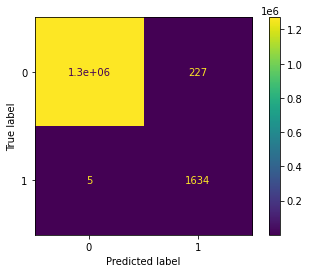

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, final_pred_rf);
print(classification_report(y_test, final_pred_rf))